# Code for Producing Figure 5

### From the Paper:  
**"The Cultural Macroevolution of Arcade Video Games: Innovation, Collaboration, and Collapse"**  

**Authors:**  
Sergi Valverde, Blai Vidiella, Andrej Spiridonov, R. Alexander Bentley  

**Date:** April 24, 2025  
**Location:** Barcelona  

This script generates **Figure 5**, which analyzes the **diversity of arcade game traits** over time.  
It specifically compares **collapsing** (e.g., "Maze dead-ends") vs. **non-collapsing** categories (e.g., "Fighter") based on the evolution of two key technological traits, i.e., ROM size (`log_rom_size`) and Clock speed (`log_clock_speed`).  A category is considered **collapsing** if the number of "bootleg" games **exceeds** the number of collaborative innovations.  This is determined using `find_collapsing_categories()`, which returns collapsing subcategories and the category IDs of collapsing games.  The script applies Heap’s Law (a power-law function) to model how unique traits accumulate over time.  

**Data Source**  
- The script loads data from `arcade.csv`, a dataset containing arcade game information.  
- Each row represents an arcade game with attributes such as:  
  - `main_category` (e.g., Shooter, Fighter, Maze)  
  - `sub_category` (e.g., Aerial Combat, Gun-Based)  
  - `log_rom_size` (log-transformed ROM storage size)  
  - `log_clock_speed` (log-transformed CPU clock speed)  
  - `collaboration` (e.g., bootleg vs. collaboration)  

**Requirements**  
To run this script, install the following Python libraries:  

```bash
pip install pandas numpy matplotlib seaborn scipy


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7822 entries, 0 to 7821
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       7822 non-null   int64  
 1   year             7822 non-null   float64
 2   title            7822 non-null   object 
 3   firm             7822 non-null   object 
 4   firm_id          7822 non-null   int64  
 5   log_rom_size     7822 non-null   float64
 6   log_clock_speed  7822 non-null   float64
 7   collaboration    7822 non-null   object 
 8   main_category    7822 non-null   object 
 9   sub_category     7822 non-null   object 
 10  category_id      7822 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 672.3+ KB
None
Finding collapsing categories for Maze
Finding collapsing categories for Shooter
Subcategories in dataset: {'Collect', 'Driving', 'Shooter Small', 'Outline', 'Move and Sort', 'Cross'}
Subcategories in dataset: {'Command', 'Mis

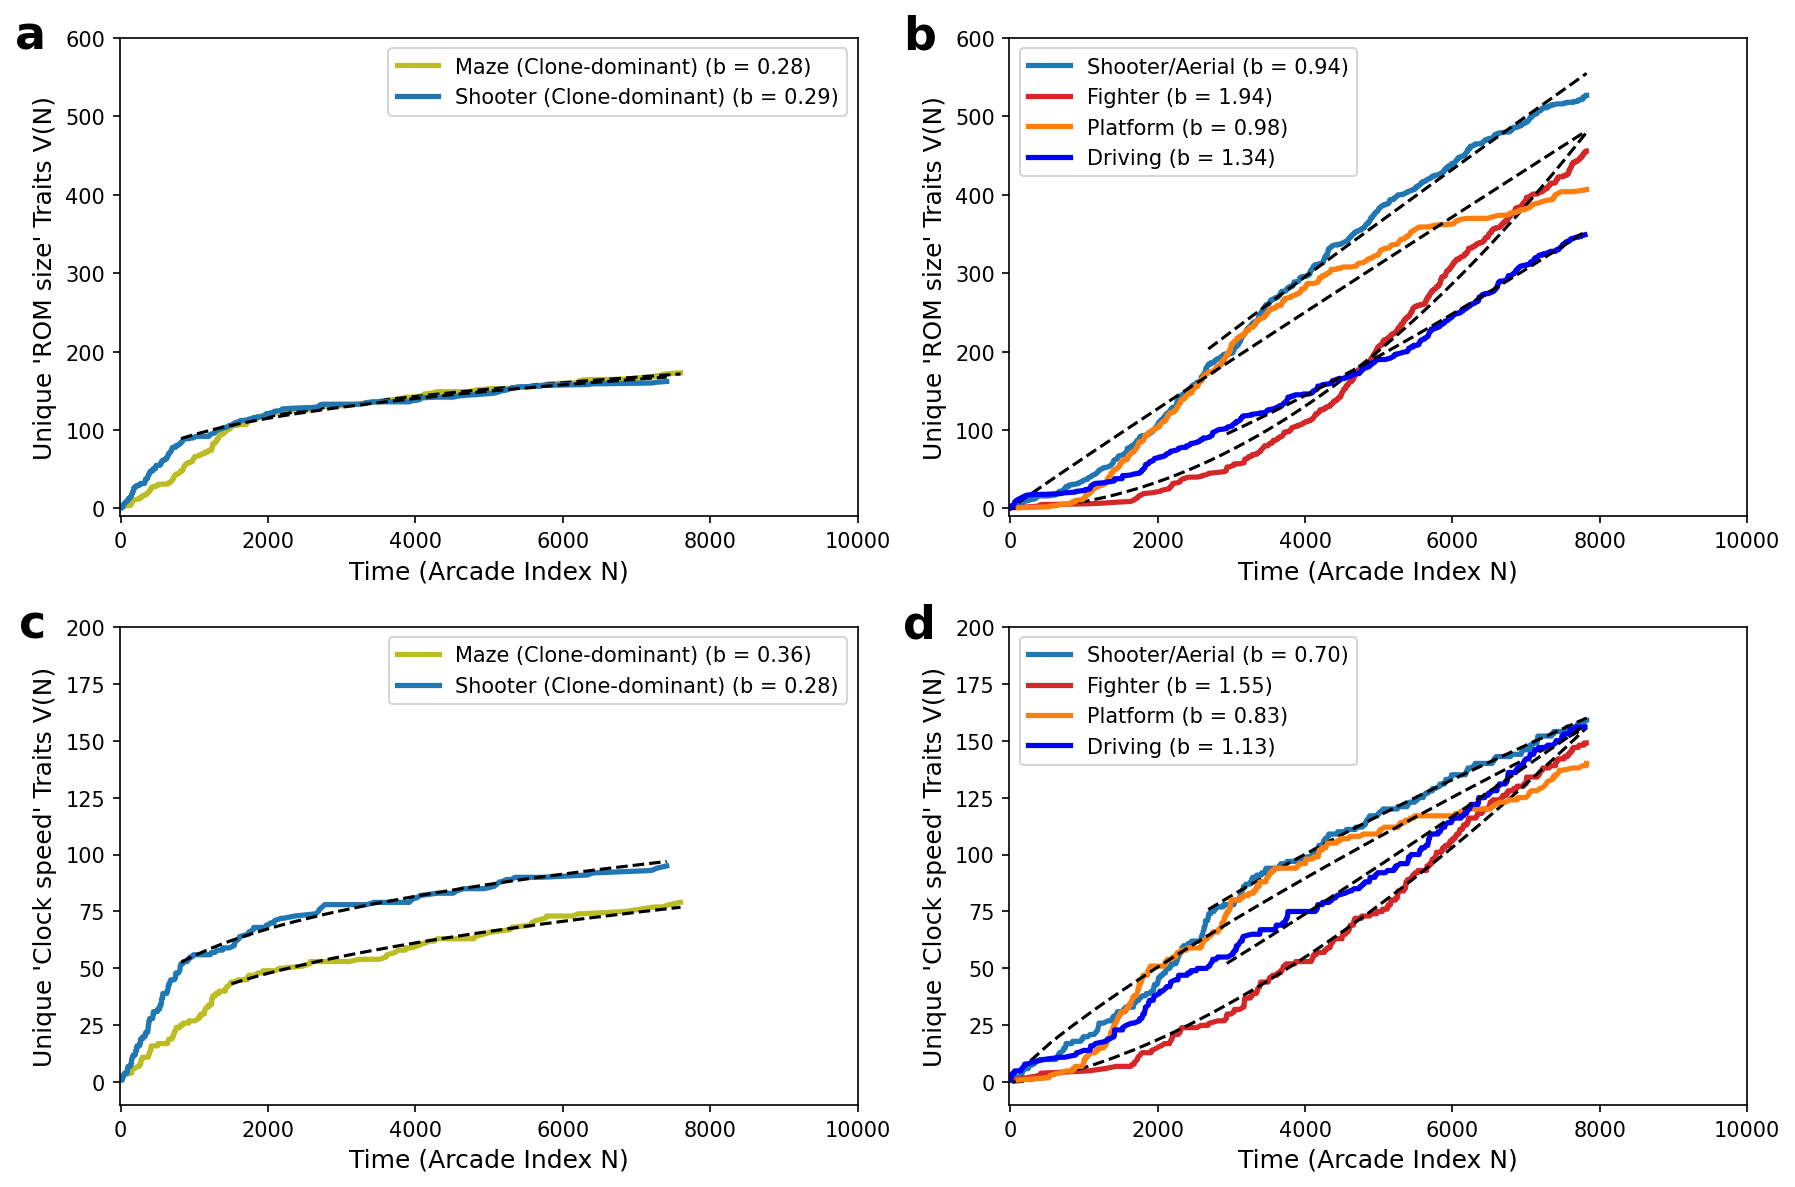

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import gaussian_kde, linregress
from scipy.optimize import curve_fit

# Suppress warnings
warnings.filterwarnings("ignore")

# Load dataset
df_prod = pd.read_csv("arcade.csv")
print(df_prod.info())


# Create dictionary mapping from category_id to (main_category, sub_category)
category_map = (
    df_prod
    .drop_duplicates(subset="category_id")[["category_id", "main_category", "sub_category"]]
    .set_index("category_id")
    .apply(tuple, axis=1)
    .to_dict()
)

# -----------------------------------
# FUNCTIONS
# -----------------------------------

def get_trait_evo(df, trait_col="log_rom_size"):
    """Extracts trait evolution data as a list of (index, value) pairs."""
    return [(index, getattr(row, trait_col)) for index, row in df.iterrows()]

def get_trait_diversity(df, trait_col="log_rom_size"):
    """Computes the cumulative number of unique trait values over time."""
    print(f"Subcategories in dataset: {set(df['sub_category'])}")
    
    trait_evolution = sorted(get_trait_evo(df, trait_col))
    times, values = zip(*trait_evolution)
    
    times = np.array(times)
    values = np.array(values)
    
    # Sort by time index while preserving gaps
    sorted_indices = np.argsort(times)
    original_times = times[sorted_indices]
    values_sorted = values[sorted_indices]
    
    # Compute cumulative number of unique traits
    unique_counts = []
    seen_traits = set()
    
    for value in values_sorted:
        seen_traits.add(value)
        unique_counts.append(len(seen_traits))
    
    return np.array(original_times), np.array(unique_counts)

def find_collapsing_categories(df, main_cat):
    """
    Identifies subcategories where imitation ('bootleg') occurs more than collaboration.
    Returns collapsing subcategories and their corresponding category IDs.
    """
    print(f"Finding collapsing categories for {main_cat}")
    
    df_main = df[df['main_category'] == main_cat]
    collapsing_subcats = {
        sub_cat for sub_cat, group in df_main.groupby('sub_category')
        if group['collaboration'].value_counts().get('bootleg', 0) > 
           group['collaboration'].value_counts().get('collaboration', 0)
    }
    
    collapsing_ids = list(df_main[df_main['sub_category'].isin(collapsing_subcats)]['category_id'].unique())
    
    return collapsing_subcats, collapsing_ids

def load_niche_category(df, main_cat, sub_cat_ids=None):
    """Loads data for a specific main category or subcategories."""
    if sub_cat_ids:
        return df[df['category_id'].isin(sub_cat_ids)]
    return df[df['main_category'] == main_cat]

# -----------------------------------
# DIVERSITY MODELS
# -----------------------------------

def heap_law(N, a, b):
    """Power-law function V(N) = a * N^b."""
    return a * N**b

# -----------------------------------
# PLOTTING FUNCTION
# -----------------------------------

def plot_combined_trait_diversity(df_prod):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=150)
    trait_configs = [
        ("log_rom_size", "ROM size", 600),
        ("log_clock_speed", "Clock speed", 200)
    ]
    
    labels = ['a', 'b', 'c', 'd']
    subplot_positions = [(0, 0), (0, 1), (1, 0), (1, 1)]

    for i, (trait_col, trait_title, ylim) in enumerate(trait_configs):
        # -------- COLLAPSING CATEGORIES --------
        ax_collapse = axes[subplot_positions[i*2]]

        # this is actually "clone-dominant". 
        collapsing = [
            ('Maze (Clone-dominant)', load_niche_category(df_prod, 'Maze', find_collapsing_categories(df_prod, 'Maze')[1]), 300, "tab:olive"),
            ('Shooter (Clone-dominant)', load_niche_category(df_prod, 'Shooter', find_collapsing_categories(df_prod, 'Shooter')[1]), 400, 'tab:blue')
        ]
        
        for label, niche, transient, color in collapsing:
            N, unique_counts = get_trait_diversity(niche, trait_col)
            N1, unique_counts1 = N[transient:], unique_counts[transient:]
            params, _ = curve_fit(heap_law, N1, unique_counts1, maxfev=10000)
            ax_collapse.plot(N, unique_counts, linewidth=2.5, color=color, label=f"{label} (b = {params[1]:.2f})")
            ax_collapse.plot(N1, heap_law(N1, *params), color='black', linestyle="dashed")
        
        ax_collapse.set_xlabel("Time (Arcade Index N)", fontsize=12)
        ax_collapse.set_ylabel(f"Unique '{trait_title}' Traits V(N)", fontsize=12)
        ax_collapse.set_ylim(-10, ylim)
        ax_collapse.set_xlim(-10, 10000)
        ax_collapse.legend(fontsize=10)
        
        # -------- NON-COLLAPSING CATEGORIES --------
        ax_noncollapse = axes[subplot_positions[i*2 + 1]]
        aerial_combat_ids = {0, 14, 21, 26, 47, 52}
        # Print the category map for aerial combat IDs (for documentation in the Appendix B )
        for cat in aerial_combat_ids:
            print ( cat, category_map[cat] )    

        non_collapsing = [
            ('Shooter/Aerial', load_niche_category(df_prod, 'Shooter', aerial_combat_ids), 400, 'tab:blue'),
            ('Fighter', load_niche_category(df_prod, 'Fighter'), 0, 'tab:red'),
            ('Platform', load_niche_category(df_prod, 'Platform'), 0, 'tab:orange'),
            ('Driving', load_niche_category(df_prod, 'Driving'), 200, 'blue')
        ]
        
        for label, niche, transient, color in non_collapsing:
            N, unique_counts = get_trait_diversity(niche, trait_col)
            N1, unique_counts1 = N[transient:], unique_counts[transient:]
            params, _ = curve_fit(heap_law, N1, unique_counts1, maxfev=10000)
            ax_noncollapse.plot(N, unique_counts, linewidth=2.5, color=color, label=f"{label} (b = {params[1]:.2f})")
            ax_noncollapse.plot(N1, heap_law(N1, *params), color='black', linestyle="dashed")
        
        ax_noncollapse.set_xlabel("Time (Arcade Index N)", fontsize=12)
        ax_noncollapse.set_ylabel(f"Unique '{trait_title}' Traits V(N)", fontsize=12)
        ax_noncollapse.set_ylim(-10, ylim)
        ax_noncollapse.set_xlim(-10, 10000)
        ax_noncollapse.legend(fontsize=10)
    

    
    # Add subplot labels
    for label, (i, j) in zip(labels, subplot_positions):
        axes[i, j].text(-0.1, 1.05, label, transform=axes[i, j].transAxes,
                        fontsize=22, fontweight='bold', va='top', ha='right')
    
    fig.tight_layout()

# Call the new plotting function
plot_combined_trait_diversity(df_prod)
plt.savefig("fig5.svg", dpi=300, bbox_inches='tight')
plt.show()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7822 entries, 0 to 7821
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       7822 non-null   int64  
 1   year             7822 non-null   float64
 2   title            7822 non-null   object 
 3   firm             7822 non-null   object 
 4   firm_id          7822 non-null   int64  
 5   log_rom_size     7822 non-null   float64
 6   log_clock_speed  7822 non-null   float64
 7   collaboration    7822 non-null   object 
 8   main_category    7822 non-null   object 
 9   sub_category     7822 non-null   object 
 10  category_id      7822 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 672.3+ KB
None
Finding collapsing categories for Maze
Finding collapsing categories for Shooter
Subcategories in dataset: {'Collect', 'Driving', 'Shooter Small', 'Outline', 'Move and Sort', 'Cross'}
Subcategories in dataset: {'Command', 'Mis

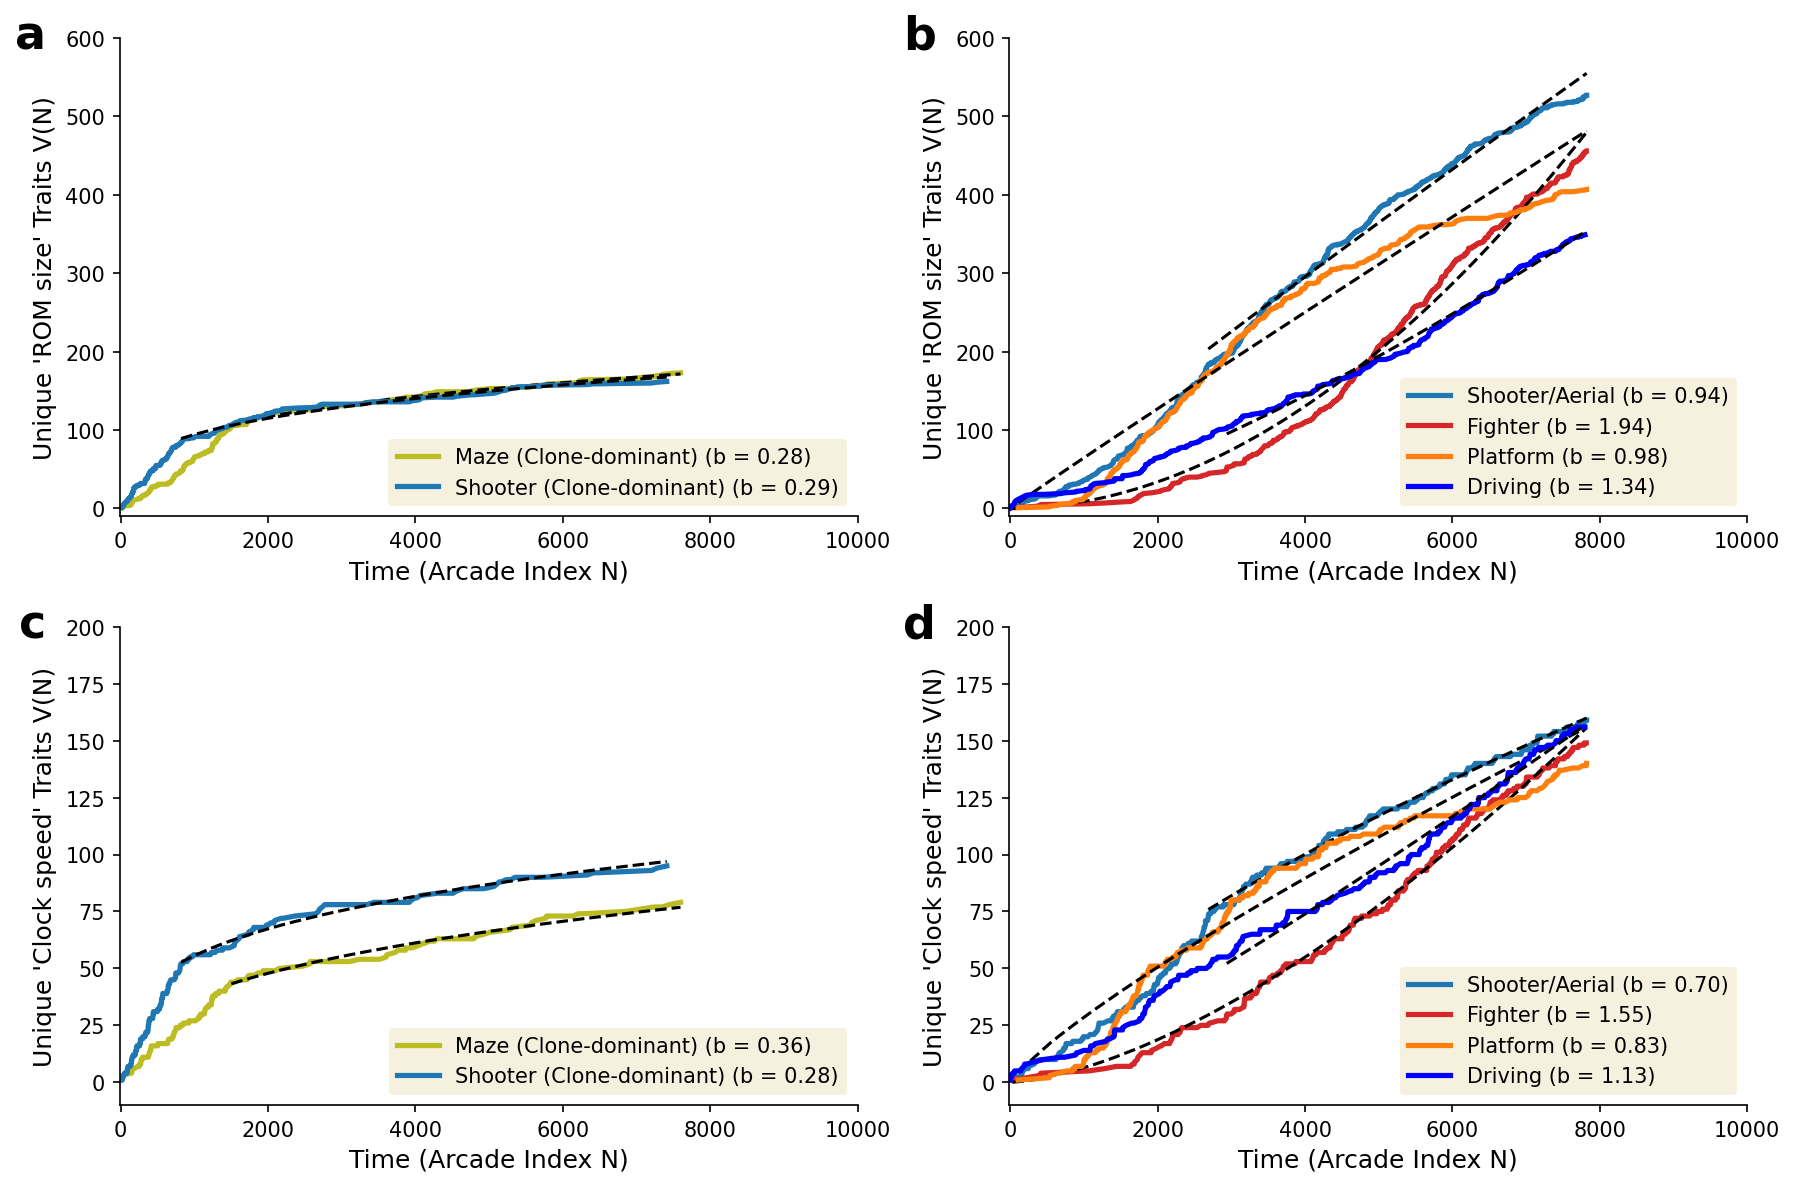

In [30]:
# Suppress warnings
warnings.filterwarnings("ignore")

# Load dataset
df_prod = pd.read_csv("arcade.csv")
print(df_prod.info())


# Create dictionary mapping from category_id to (main_category, sub_category)
category_map = (
    df_prod
    .drop_duplicates(subset="category_id")[["category_id", "main_category", "sub_category"]]
    .set_index("category_id")
    .apply(tuple, axis=1)
    .to_dict()
)

# -----------------------------------
# FUNCTIONS
# -----------------------------------

def get_trait_evo(df, trait_col="log_rom_size"):
    """Extracts trait evolution data as a list of (index, value) pairs."""
    return [(index, getattr(row, trait_col)) for index, row in df.iterrows()]

def get_trait_diversity(df, trait_col="log_rom_size"):
    """Computes the cumulative number of unique trait values over time."""
    print(f"Subcategories in dataset: {set(df['sub_category'])}")
    
    trait_evolution = sorted(get_trait_evo(df, trait_col))
    times, values = zip(*trait_evolution)
    
    times = np.array(times)
    values = np.array(values)
    
    # Sort by time index while preserving gaps
    sorted_indices = np.argsort(times)
    original_times = times[sorted_indices]
    values_sorted = values[sorted_indices]
    
    # Compute cumulative number of unique traits
    unique_counts = []
    seen_traits = set()
    
    for value in values_sorted:
        seen_traits.add(value)
        unique_counts.append(len(seen_traits))
    
    return np.array(original_times), np.array(unique_counts)

def find_collapsing_categories(df, main_cat):
    """
    Identifies subcategories where imitation ('bootleg') occurs more than collaboration.
    Returns collapsing subcategories and their corresponding category IDs.
    """
    print(f"Finding collapsing categories for {main_cat}")
    
    df_main = df[df['main_category'] == main_cat]
    collapsing_subcats = {
        sub_cat for sub_cat, group in df_main.groupby('sub_category')
        if group['collaboration'].value_counts().get('bootleg', 0) > 
           group['collaboration'].value_counts().get('collaboration', 0)
    }
    
    collapsing_ids = list(df_main[df_main['sub_category'].isin(collapsing_subcats)]['category_id'].unique())
    
    return collapsing_subcats, collapsing_ids

def load_niche_category(df, main_cat, sub_cat_ids=None):
    """Loads data for a specific main category or subcategories."""
    if sub_cat_ids:
        return df[df['category_id'].isin(sub_cat_ids)]
    return df[df['main_category'] == main_cat]

# -----------------------------------
# DIVERSITY MODELS
# -----------------------------------

def heap_law(N, a, b):
    """Power-law function V(N) = a * N^b."""
    return a * N**b

# -----------------------------------
# PLOTTING FUNCTION
# -----------------------------------

def plot_combined_trait_diversity(df_prod):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=150)
    trait_configs = [
        ("log_rom_size", "ROM size", 600),
        ("log_clock_speed", "Clock speed", 200)
    ]
    
    labels = ['a', 'b', 'c', 'd']
    subplot_positions = [(0, 0), (0, 1), (1, 0), (1, 1)]

    for i, (trait_col, trait_title, ylim) in enumerate(trait_configs):
        # -------- COLLAPSING CATEGORIES --------
        ax_collapse = axes[subplot_positions[i*2]]

        # this is actually "clone-dominant". 
        collapsing = [
            ('Maze (Clone-dominant)', load_niche_category(df_prod, 'Maze', find_collapsing_categories(df_prod, 'Maze')[1]), 300, "tab:olive"),
            ('Shooter (Clone-dominant)', load_niche_category(df_prod, 'Shooter', find_collapsing_categories(df_prod, 'Shooter')[1]), 400, 'tab:blue')
        ]
        
        for label, niche, transient, color in collapsing:
            N, unique_counts = get_trait_diversity(niche, trait_col)
            N1, unique_counts1 = N[transient:], unique_counts[transient:]
            params, _ = curve_fit(heap_law, N1, unique_counts1, maxfev=10000)
            ax_collapse.plot(N, unique_counts, linewidth=2.5, color=color, label=f"{label} (b = {params[1]:.2f})")
            ax_collapse.plot(N1, heap_law(N1, *params), color='black', linestyle="dashed")
        
        ax_collapse.set_xlabel("Time (Arcade Index N)", fontsize=12)
        ax_collapse.set_ylabel(f"Unique '{trait_title}' Traits V(N)", fontsize=12)
        ax_collapse.set_ylim(-10, ylim)
        ax_collapse.set_xlim(-10, 10000)
        ax_collapse.legend(fontsize=10,loc='lower right',edgecolor='None',facecolor='#f4eed727')
        
        # -------- NON-COLLAPSING CATEGORIES --------
        ax_noncollapse = axes[subplot_positions[i*2 + 1]]
        aerial_combat_ids = {0, 14, 21, 26, 47, 52}
        # Print the category map for aerial combat IDs (for documentation in the Appendix B )
        for cat in aerial_combat_ids:
            print ( cat, category_map[cat] )    

        non_collapsing = [
            ('Shooter/Aerial', load_niche_category(df_prod, 'Shooter', aerial_combat_ids), 400, 'tab:blue'),
            ('Fighter', load_niche_category(df_prod, 'Fighter'), 0, 'tab:red'),
            ('Platform', load_niche_category(df_prod, 'Platform'), 0, 'tab:orange'),
            ('Driving', load_niche_category(df_prod, 'Driving'), 200, 'blue')
        ]
        
        for label, niche, transient, color in non_collapsing:
            N, unique_counts = get_trait_diversity(niche, trait_col)
            N1, unique_counts1 = N[transient:], unique_counts[transient:]
            params, _ = curve_fit(heap_law, N1, unique_counts1, maxfev=10000)
            ax_noncollapse.plot(N, unique_counts, linewidth=2.5, color=color, label=f"{label} (b = {params[1]:.2f})")
            ax_noncollapse.plot(N1, heap_law(N1, *params), color='black', linestyle="dashed")
        
        ax_noncollapse.set_xlabel("Time (Arcade Index N)", fontsize=12)
        ax_noncollapse.set_ylabel(f"Unique '{trait_title}' Traits V(N)", fontsize=12)
        ax_noncollapse.set_ylim(-10, ylim)
        ax_noncollapse.set_xlim(-10, 10000)
        ax_noncollapse.legend(fontsize=10,loc='lower right',edgecolor='None',facecolor='#f4eed727')
        
        
        ax_collapse.spines[['right', 'top']].set_visible(False)
        ax_noncollapse.spines[['right', 'top']].set_visible(False)
        #axes[subplot_positions[0]].legend(loc='lower right')
        #axes[subplot_positions[1]].legend(loc='lower right')

    
    # Add subplot labels
    for label, (i, j) in zip(labels, subplot_positions):
        axes[i, j].text(-0.1, 1.05, label, transform=axes[i, j].transAxes,
                        fontsize=22, fontweight='bold', va='top', ha='right')
    
    fig.tight_layout()

# Call the new plotting function
plot_combined_trait_diversity(df_prod)
plt.savefig("fig5.svg", dpi=300, bbox_inches='tight')
plt.show()
